# House Price vs Graduation rate

## 0. Import libary

In [23]:
import pandas as pd
import os
import re
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import math

warnings.filterwarnings("ignore")

# Feature Enginnering

## 1. Process NA value

In [24]:
#Count the number of missing values
def miss_analy(df,state,rate):

    missing=df.isnull().sum().reset_index().rename(columns={'index':'Variable',0:'missNum'})

    #Calculate the missing proportion
    missing['missRate']=missing['missNum']/df.shape[0]

    #Sorted by deletion rate
    miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False) 

    #Return columns with missing information
    if state=='larger':
        miss_analy=miss_analy[miss_analy.missRate>rate]
        print(miss_analy.shape[0] ,'columns have missing values percentage '+state+' than', rate) 
    elif state=='smaller':
        miss_analy=miss_analy[miss_analy.missRate<rate]
        print(miss_analy.shape[0] ,'columns have missing values percentage '+state+' than', rate) 
    
    df=miss_analy.T
    new_header = df.iloc[0]  
    df = df[1:] 
    df.columns = new_header 
    return df

# miss_analy(merged_2022,'larger',0.2)  
# miss_analy(merged_2022,state=None,rate=None)

In [25]:
# Read data & Drop rows where >50% columns are null
for year in [2017, 2018,2019,2021,2022]:
    globals()[f"merged_{year}"]=pd.read_csv('TX_data/merged_'+str(year)+'.csv')
    globals()[f"merged_{year}"]=globals()[f"merged_{year}"].drop(columns=['Unnamed: 0'])

    globals()[f"merged_{year}"]=globals()[f"merged_{year}"].drop(columns=list(miss_analy(globals()[f"merged_{year}"],'larger',0.5).columns))

431 columns have missing values percentage larger than 0.5
571 columns have missing values percentage larger than 0.5
631 columns have missing values percentage larger than 0.5
395 columns have missing values percentage larger than 0.5
386 columns have missing values percentage larger than 0.5


## 2. Focuse on 4-Year Longitudinal Rate (Gr 9-12)

Data_field='4-Year Longitudinal Rate (Gr 9-12)'
Data_Level='District'
Subcategory='Graduates'   # 'Graduates and GED', Graduates and TxCHSE

-> element=['DA3C4X15R','DA3C4X16R','DA3C4X17R','DA3C4X18R','DA3C4X19R','DA3C4X20R','DA3C4X21R']

### 2.1 Combine df

In [26]:
dfs = []

# Loop over the years and read in each DataFrame, cleaning the 'DISTRICT' column
for year in [2017, 2018, 2019, 2021, 2022]:
    df = pd.read_csv('TX_data/TAPR_District/TAPR_'+str(year)+'.csv', na_values=['.'])
    df['DISTRICT'] = df['DISTRICT'].str.replace("'", '').astype('float64')
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])    
    dfs.append(df)

# Merge the DataFrames on the 'DISTRICT' column
merged_df = pd.merge(dfs[0], dfs[1], on='DISTRICT', how='inner')
for df in dfs[2:]:
    merged_df = pd.merge(merged_df, df, on=['DISTRICT'], how='inner')
    
merged_df=merged_df[['DISTRICT']+list(merged_df.columns[merged_df.columns.str.startswith('DA3C4X')])]
merged_df=merged_df.T.drop_duplicates().T
merged_df.columns = [col.replace('_x', '') for col in merged_df.columns]


# convert
merged_df=merged_df.melt(id_vars='DISTRICT', var_name='year', value_name='DA3C4X')
merged_df['year']='20'+merged_df['year'].str[-3:-1]
merged_df['year']=merged_df['year'].astype(int)
merged_df=merged_df.sort_values(['DISTRICT','year'])

In [27]:
data=pd.read_csv('TX_data/HousePrice/TX_houseprice.csv').sort_values(['zipcode','DISTRICT','period_end'])
data=data.rename(columns={'DISTNAME':'distname'})
data=data[data['period_end'].str.endswith('-12-31')]
data['period_end'] = pd.to_datetime(data['period_end'])
data

,zipcode,period_end,median_ppsf,area,year,DISTRICT,distname
9,75001,2012-12-31,135.382724,1846.616713,2012,57905.0,DALLAS ISD
21,75001,2013-12-31,129.449838,2044.807500,2013,57905.0,DALLAS ISD
33,75001,2014-12-31,142.466823,2028.542466,2014,57905.0,DALLAS ISD
45,75001,2015-12-31,147.026432,2006.441948,2015,57905.0,DALLAS ISD
57,75001,2016-12-31,163.327769,1910.269165,2016,57905.0,DALLAS ISD
...,...,...,...,...,...,...,...
203728,79936,2018-12-31,87.094499,1527.076923,2018,71909.0,SOCORRO ISD
203764,79936,2019-12-31,94.482237,1450.008000,2019,71909.0,SOCORRO ISD
203800,79936,2020-12-31,102.657005,1509.882353,2020,71909.0,SOCORRO ISD
203836,79936,2021-12-31,119.493671,1472.881356,2021,71909.0,SOCORRO ISD


In [71]:
# merge
df=data.merge(merged_df,how='left',on=['DISTRICT','year'])

df['zipcode'] = df['zipcode'].astype(str).astype('category')
df['DISTRICT'] = df['DISTRICT'].astype(str).astype('category')
df['distname'] = df['distname'].astype(str).astype('category')
df['year'] = pd.to_datetime(df['year'], format='%Y').dt.year

df=df[['year','zipcode', 'DISTRICT','distname','area','median_ppsf','DA3C4X']] #, 'period_end' 
#df=df[(df['year']>=2015) & (df['year']<=2021)].reset_index(drop=True)

In [72]:
df.dtypes

year              int64
zipcode        category
DISTRICT       category
distname       category
area            float64
median_ppsf     float64
DA3C4X          float64
dtype: object

In [73]:
df

,year,zipcode,DISTRICT,distname,area,median_ppsf,DA3C4X
0,2012,75001,57905.0,DALLAS ISD,1846.616713,135.382724,NaN
1,2013,75001,57905.0,DALLAS ISD,2044.807500,129.449838,NaN
2,2014,75001,57905.0,DALLAS ISD,2028.542466,142.466823,NaN
3,2015,75001,57905.0,DALLAS ISD,2006.441948,147.026432,88.0
4,2016,75001,57905.0,DALLAS ISD,1910.269165,163.327769,88.0
...,...,...,...,...,...,...,...
17043,2018,79936,71909.0,SOCORRO ISD,1527.076923,87.094499,92.5
17044,2019,79936,71909.0,SOCORRO ISD,1450.008000,94.482237,94.2
17045,2020,79936,71909.0,SOCORRO ISD,1509.882353,102.657005,94.2
17046,2021,79936,71909.0,SOCORRO ISD,1472.881356,119.493671,91.7


### 2.2 Process df -> create new columns

In [74]:
group = df.groupby(['zipcode','DISTRICT','distname'])

df['Average 4yr Graduation Rate']=group['DA3C4X'].apply(lambda x:( x + x.shift(1)+ x.shift(2)+  x.shift(3))/4)
# # Run with 0 lag (column G & column J)
df['grad_rate_change'] = group['Average 4yr Graduation Rate'].pct_change() * 100



df['Year-over-year change%'] = group['median_ppsf'].apply(lambda x: x / x.shift(1) - 1) *100  
df['Rolling 4-yr Change%']=group['median_ppsf'].apply(lambda x: x / x.shift(3) - 1) *100
df['Average 4yr PPSF']=group['median_ppsf'].apply(lambda x:( x + x.shift(1)+ x.shift(2)+  x.shift(3))/4)

# Run with 1-year lag: 2017 Graduation rate change vs. 2018 home price change
df['home_price_change_1_lag'] = group['Average 4yr PPSF'].pct_change(periods=1) * 100

# Run with 2-year lag: 2017 Graduation rate change vs. 2019 home price change
df['home_price_change_2_lag'] = group['Average 4yr PPSF'].pct_change(periods=2) * 100

# Run with 3-year lag: 2017 Graduation rate change vs. 2020 home price change
df['home_price_change_3_lag'] = group['Average 4yr PPSF'].pct_change(periods=3) * 100

In [75]:
df.head(11)

,year,zipcode,DISTRICT,distname,area,median_ppsf,DA3C4X,Average 4yr Graduation Rate,grad_rate_change,Year-over-year change%,Rolling 4-yr Change%,Average 4yr PPSF,home_price_change_1_lag,home_price_change_2_lag,home_price_change_3_lag
0,2012,75001,57905.0,DALLAS ISD,1846.616713,135.382724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,75001,57905.0,DALLAS ISD,2044.807500,129.449838,NaN,NaN,NaN,-4.382306,NaN,NaN,NaN,NaN,NaN
2,2014,75001,57905.0,DALLAS ISD,2028.542466,142.466823,NaN,NaN,NaN,10.055621,NaN,NaN,NaN,NaN,NaN
3,2015,75001,57905.0,DALLAS ISD,2006.441948,147.026432,88.0,NaN,NaN,3.200471,8.600586,138.581454,NaN,NaN,NaN
4,2016,75001,57905.0,DALLAS ISD,1910.269165,163.327769,88.0,NaN,NaN,11.087351,26.170701,145.567715,5.041267,NaN,NaN
5,2017,75001,57905.0,DALLAS ISD,2091.750332,179.076343,88.4,NaN,NaN,9.642313,25.696874,157.974342,8.522924,13.993855,NaN
6,2018,75001,57905.0,DALLAS ISD,2121.569859,169.685669,87.4,87.95,NaN,-5.243950,15.411676,164.779053,4.307479,13.197526,18.904116
7,2019,75001,57905.0,DALLAS ISD,1949.843077,170.782974,85.6,87.35,-0.682206,0.646670,4.564567,170.718189,3.604303,8.067036,17.277508
8,2020,75001,57905.0,DALLAS ISD,1813.636364,192.982456,83.0,86.10,-1.431025,12.998650,7.765466,178.131861,4.342637,8.103462,12.759996
9,2021,75001,57905.0,DALLAS ISD,1972.770214,202.760563,81.2,84.30,-2.090592,5.066837,19.491861,184.052916,3.323973,7.810959,11.696792


In [76]:
df.iloc[:,5:].describe()

,median_ppsf,DA3C4X,Average 4yr Graduation Rate,grad_rate_change,Year-over-year change%,Rolling 4-yr Change%,Average 4yr PPSF,home_price_change_1_lag,home_price_change_2_lag,home_price_change_3_lag
count,17048.000000,9866.000000,5176.000000,5182.000000,15223.000000,11748.000000,11748.000000,10078.000000,8514.000000,7000.000000
mean,122.621415,90.876110,90.932115,0.134946,14.804782,38.119035,120.580296,9.462716,19.468613,29.627791
std,89.717074,13.717312,12.552473,2.655825,77.333833,108.477624,60.203740,15.825117,26.199790,33.136290
min,2.265861,-1.000000,8.925000,-25.608953,-96.558860,-91.172864,18.150370,-72.039053,-59.921223,-59.011655
25%,82.204019,89.600000,89.662500,-0.076844,2.745104,16.221504,87.151727,5.563667,11.604362,18.363855
50%,110.687750,94.500000,94.500000,0.000000,8.792891,29.557775,109.867305,8.841226,17.830487,26.896713
75%,145.511779,97.500000,97.175000,0.432956,16.719470,44.768196,138.423034,12.043490,24.287587,36.110659
max,8021.944405,100.000000,100.000000,39.548023,5862.267277,8132.700026,2144.636236,1409.497862,1555.909476,1665.963792


In [77]:
df.dtypes

year                              int64
zipcode                        category
DISTRICT                       category
distname                       category
area                            float64
median_ppsf                     float64
DA3C4X                          float64
Average 4yr Graduation Rate     float64
grad_rate_change                float64
Year-over-year change%          float64
Rolling 4-yr Change%            float64
Average 4yr PPSF                float64
home_price_change_1_lag         float64
home_price_change_2_lag         float64
home_price_change_3_lag         float64
dtype: object

In [78]:
# apply to all school years up until 2022
df1 = df.copy()
df1['distname'] = df1['distname'].cat.codes

# apply to all school years up until 2019 (hence removing 
df2 = df[df['year']<=2019]
df2['distname'] = df2['distname'].cat.codes


# apply to all school years up until 2022 but focus on the 
key_district=pd.read_excel('TX_data/key-TX School Districts.xlsx')
district_list=key_district.loc[key_district['RANK of Impact holdings']!='No Impact Holdings','Credit\nName'].to_list()
district_list =[ x.replace('Independent School District','ISD')  for x in district_list]
print(district_list)

df3 = df[df['distname'].str.lower().isin([x.lower() for x in district_list])]
df3['distname'] = df3['distname'].cat.codes

['Dallas ISD', 'Fort Worth ISD', 'San Antonio ISD', 'Elgin ISD', 'Nacogdoches ISD', 'Brownsville ISD', 'Galena Park ISD', 'Laredo ISD', 'Kingsville ISD', 'Poteet ISD', 'Houston ISD']


In [79]:
df3.columns

Index(['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'median_ppsf',
       'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change',
       'Year-over-year change%', 'Rolling 4-yr Change%', 'Average 4yr PPSF',
       'home_price_change_1_lag', 'home_price_change_2_lag',
       'home_price_change_3_lag'],
      dtype='object')

### EDA

When both column G and J are calculated, can we run a cluster bar chart to see distribution of data points (whether or not everything is within +/-10%)?

In [80]:
def cluster_bar2(df,col1,col2,bin1,bin2,range1,range2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    if range1==None:
        range1=(np.mean(df[col1]) - 3*np.std(df[col1]),np.mean(df[col1]) + 3*np.std(df[col1]))
    if range2==None:
        range2=(np.mean(df[col2]) - 3*np.std(df[col2]),np.mean(df[col2]) + 3*np.std(df[col2]))
    
    sns.distplot(df[col1], bins=bin2, label=col1, kde=False, hist_kws={'range':range1}, ax=axes[0],color='green')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlim(range1)
    axes[0].axvline(x=10, color='red')
    axes[0].axvline(x=-10, color='red')
    axes[0].legend()

    sns.distplot(df[col2], bins=bin1, label=col2, kde=False, hist_kws={'range':range2}, ax=axes[1],color='blue')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_xlim(range2)
    axes[1].axvline(x=10, color='red')
    axes[1].axvline(x=-10, color='red')
    axes[1].legend()

    plt.show()

def cluster_bar(df,col1,bin,range):
    
    if range==None:
        range= (min(np.mean(df[col1]) - 3*np.std(df[col1]),np.mean(df[col2]) - 3*np.std(df[col2])), 
                max(np.mean(df[col1]) + 3*np.std(df[col1]),np.mean(df[col2]) + 3*np.std(df[col2])))
    if math.isnan(range[0]) and math.isnan(range[1]):
        range=(-50,50)
    
    sns.distplot(df[col1],label=col1,kde=False, bins=bin, hist_kws={'range':range})
    #sns.distplot(df[col2],label=col2,kde=False, bins=bin, hist_kws={'range':range})

    plt.legend()
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    plt.xlim(range)
    plt.axvline(x=10, color='red')
    plt.axvline(x=-10, color='red')
    plt.show()

def scatter(df,col1,col2,range_x,range_y,hue_col,title):
    df=df.ffill().bfill()
    if hue_col==None:
        sns.scatterplot(data=df, x=col1, y=col2)
    else:
        sns.scatterplot(data=df, x=col1, y=col2, hue=hue_col, alpha=0.5,palette="Set2")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(col1)
    plt.xlim(range_x)
    plt.ylim(range_y)
    plt.ylabel(col2)
    plt.title(title)
    plt.show()

In [81]:
"""
if range==None: default range would be mean ± 3var
"""

def cluster_scatter(df,col1,col2,bin,range,hue_col,title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    
    if range==None:
        range= (min(np.mean(df[col1]) - 3*np.std(df[col1]),np.mean(df[col2]) - 3*np.std(df[col2])), 
                max(np.mean(df[col1]) + 3*np.std(df[col1]),np.mean(df[col2]) + 3*np.std(df[col2])))
    if math.isnan(range[0]) and math.isnan(range[1]):
        range=(-50,50)
        
    sns.distplot(df[col1],label=col1,kde=False, bins=bin, hist_kws={'range':range}, ax=axes[0])
    sns.distplot(df[col2],label=col2,kde=False, bins=bin, hist_kws={'range':range}, ax=axes[0])
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlim(range)
    axes[0].axvline(x=10, color='red')
    axes[0].axvline(x=-10, color='red')
    axes[0].legend()
    
    if hue_col==None:
        sns.scatterplot(data=df, x=col1, y=col2, ax=axes[1])
    else:
        sns.scatterplot(data=df, x=col1, y=col2, hue=hue_col, alpha=0.5,palette="Set2", ax=axes[1])
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    axes[1].set_xlabel(col1)
    axes[1].set_ylabel(col2)
    axes[1].set_xlim(range)
    axes[1].set_ylim(range)
    
    plt.show()

####  Apply to different type: shool year & district
 - Run with 0 lag (column G vs column J)
- Run with 1-year lag: 2017 Graduation rate change vs. 2018 home price change
- Run with 2-year lag: 2017 Graduation rate change vs. 2019 home price change
- Run with 3-year lag: 2017 Graduation rate change vs. 2020 home price change

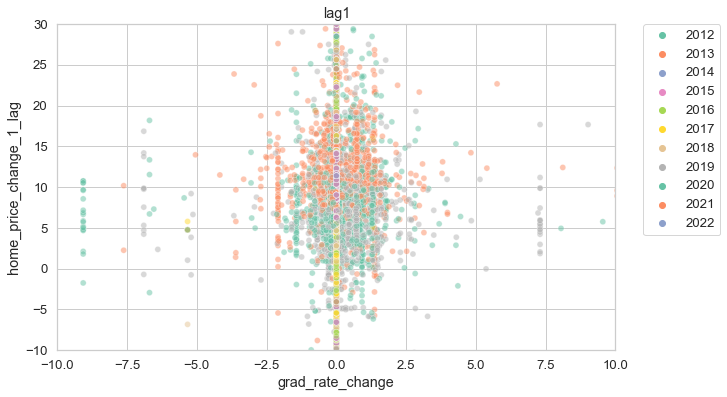

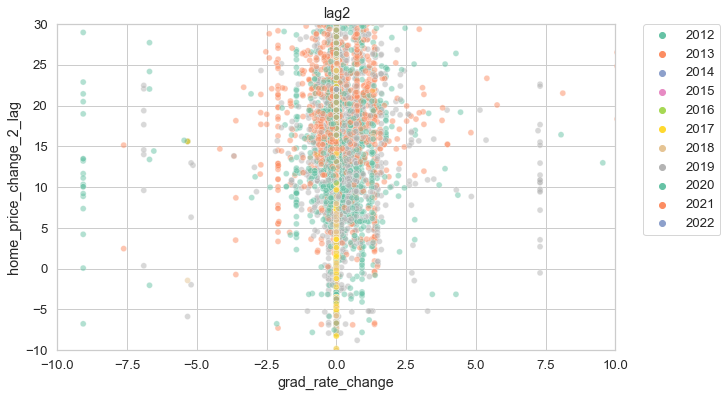

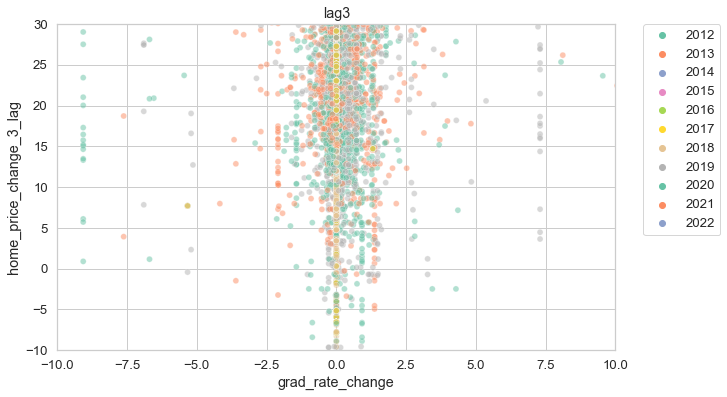

In [82]:
scatter(df1,'grad_rate_change','home_price_change_1_lag',range_x=(-10,10),range_y=(-10,30),hue_col='year',title='lag1')
scatter(df1,'grad_rate_change','home_price_change_2_lag',range_x=(-10,10),range_y=(-10,30),hue_col='year',title='lag2')
scatter(df1,'grad_rate_change','home_price_change_3_lag',range_x=(-10,10),range_y=(-10,30),hue_col='year',title='lag3')

apply to all school years up until 2022


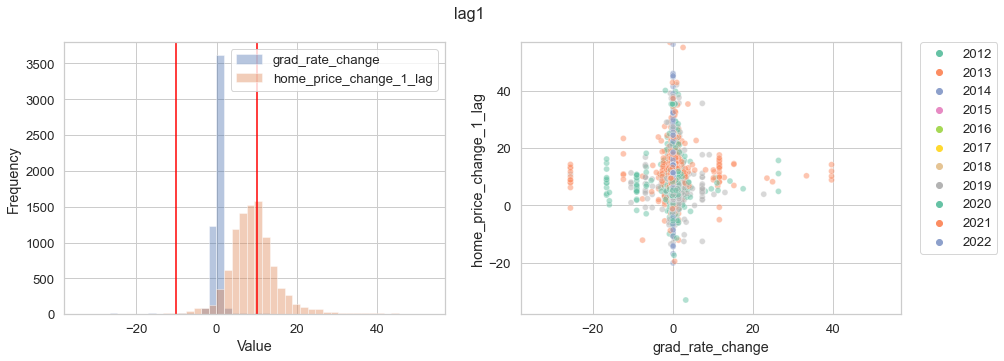

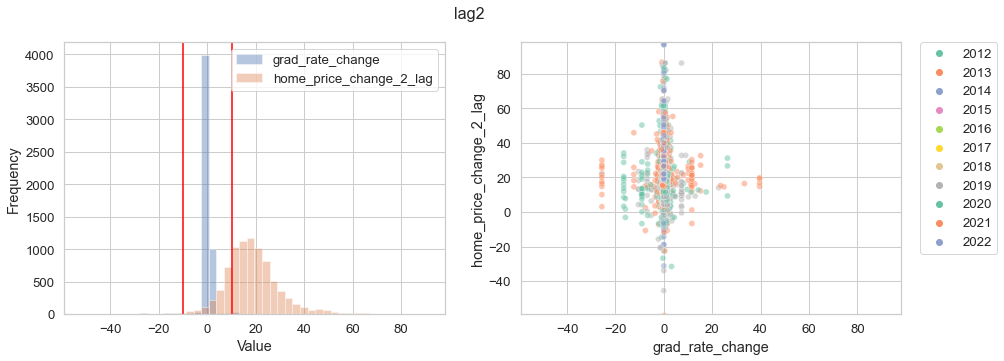

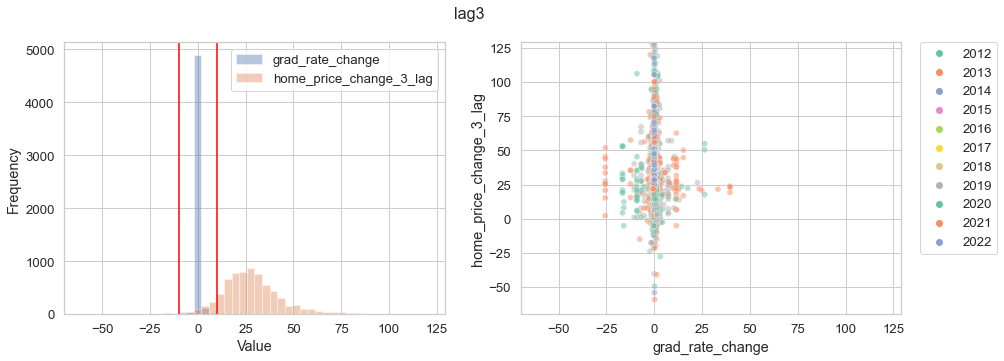

apply to all school years up until 2019 (hence removing pandemic impacted years)


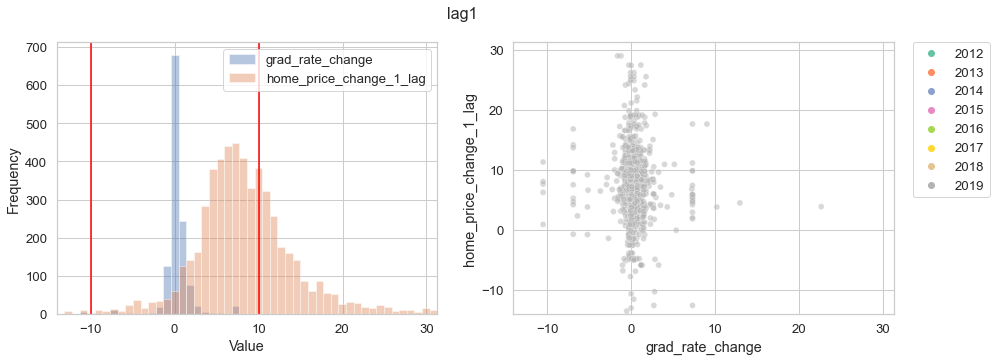

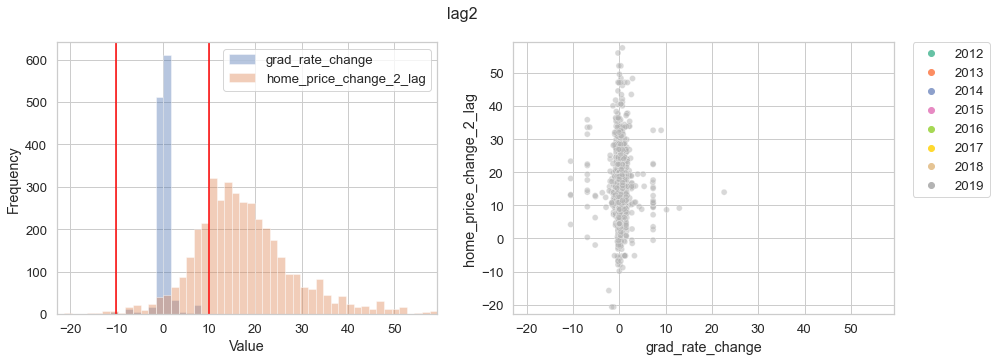

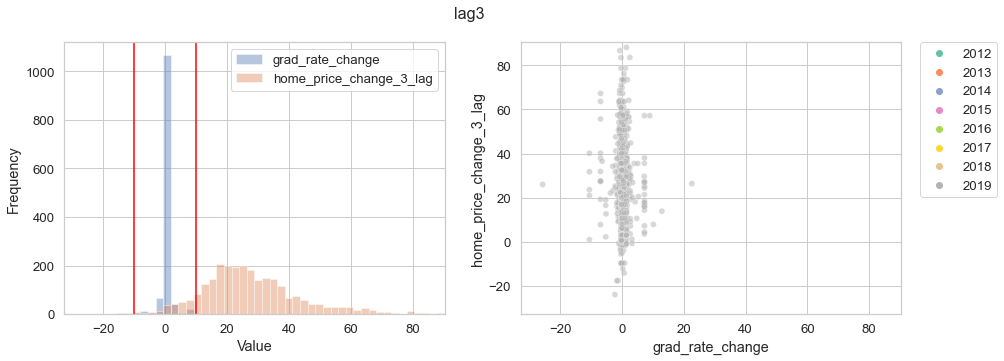

all school years up until 2022 but focus on the attached school districts (affordable only)


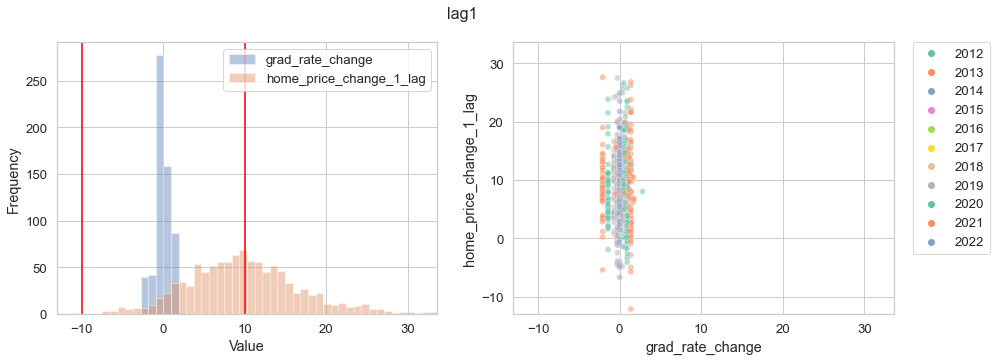

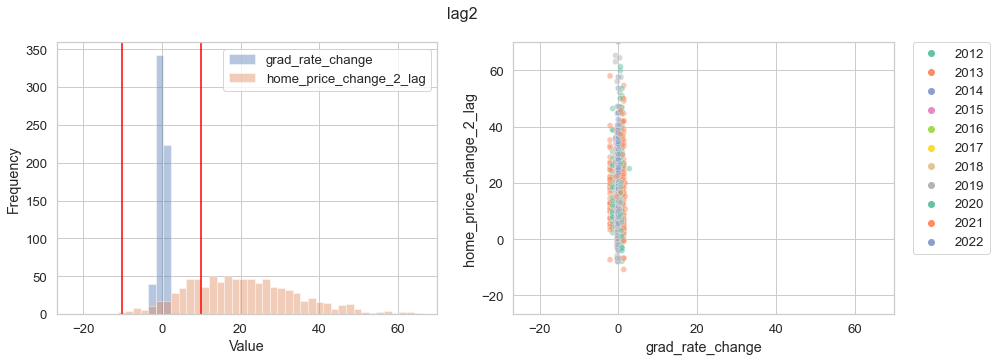

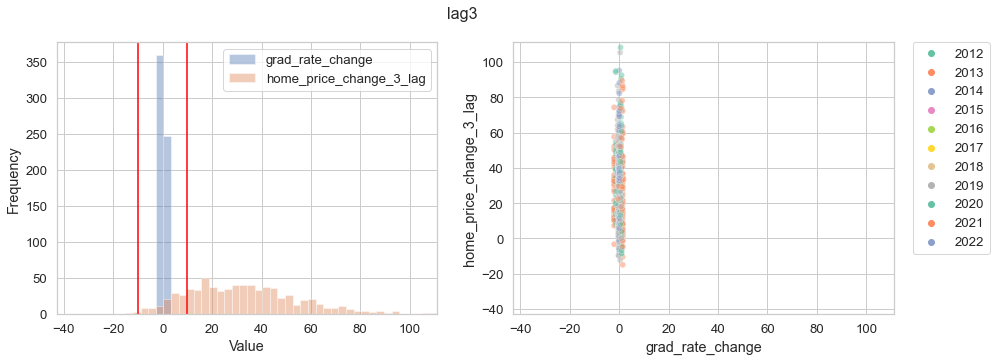

In [83]:
d_type=['apply to all school years up until 2022','apply to all school years up until 2019 (hence removing pandemic impacted years)','all school years up until 2022 but focus on the attached school districts (affordable only)']
dfs=[df1,df2,df3]

for j in range(3):
    print(d_type[j])
    for i in range(1,4):
        cluster_scatter(dfs[j], col1=f'grad_rate_change', col2=f'home_price_change_{i}_lag',bin=50,range=None,hue_col='year',title='lag'+str(i))


#### Correlation Plot

In [84]:
d_type=['apply to all school years up until 2022','apply to all school years up until 2019 (hence removing pandemic impacted years)','all school years up until 2022 but focus on the attached school districts (affordable only)']
dfs=[df1,df2,df3]

for j in range(3):
    print(d_type[j])
    for i in range(1,4):
        print('lag '+str(i)+' :',dfs[j][f'home_price_change_{i}_lag'].corr(dfs[j][f'grad_rate_change']))
    print('\n')

apply to all school years up until 2022
lag 1 : 0.006627686443558096
lag 2 : 0.002942272652877102
lag 3 : 0.0033701503552780233


apply to all school years up until 2019 (hence removing pandemic impacted years)
lag 1 : -0.022855909432156974
lag 2 : 0.0003687656027603032
lag 3 : 0.00797091176136687


all school years up until 2022 but focus on the attached school districts (affordable only)
lag 1 : 0.0332866395800717
lag 2 : 0.005847272388544755
lag 3 : -0.04229179239548325




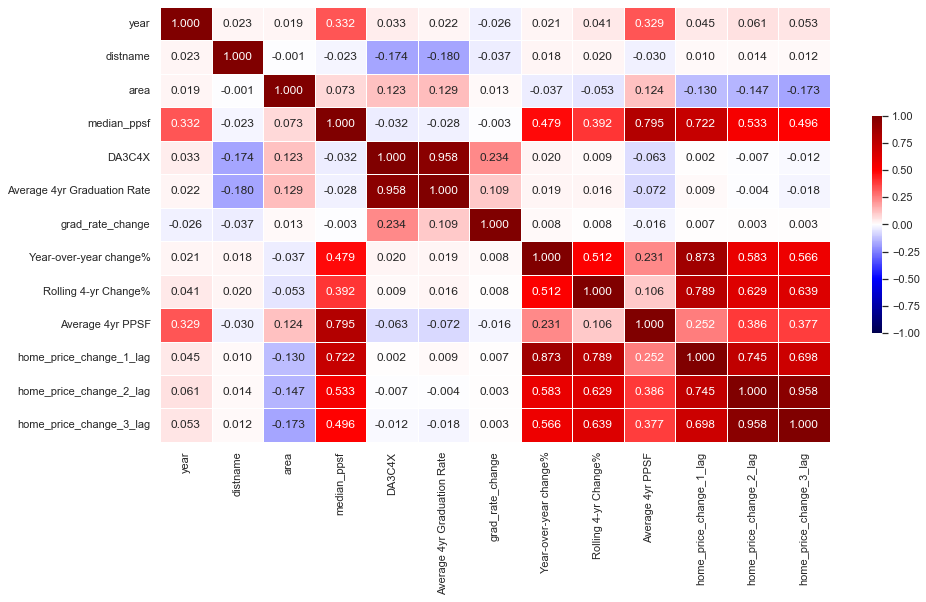

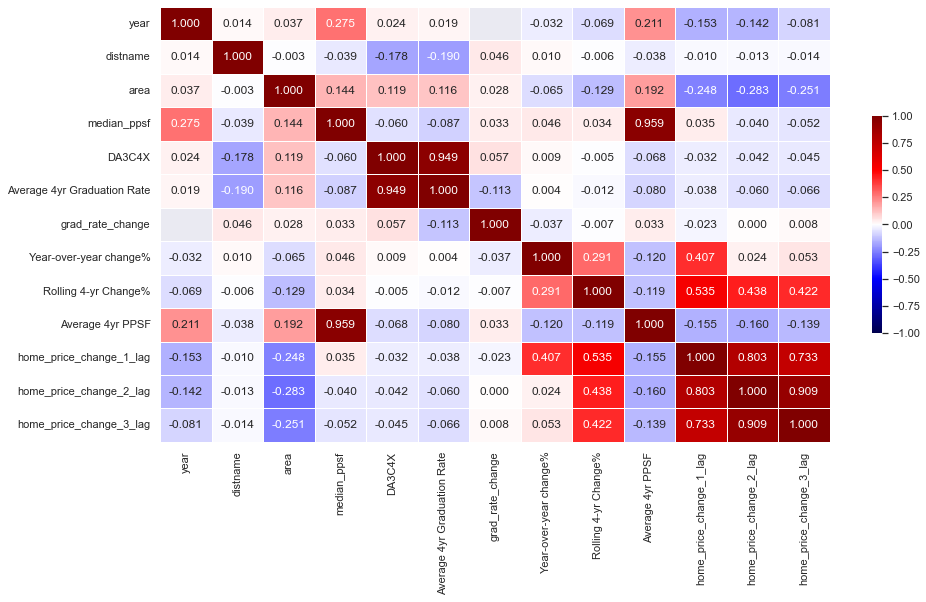

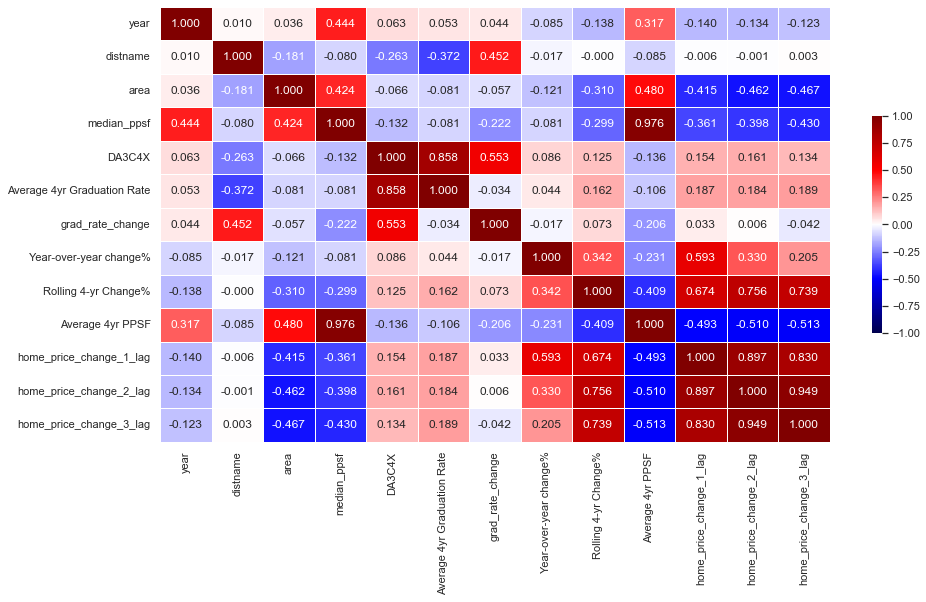

In [85]:
def corr(df):
    sns.set(font_scale=1.)
    f, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(df.corr() , 
            cmap='seismic', annot=True, fmt=".3f", vmin=-1, vmax=1, center=0,
            square=False, linewidths=.7, cbar_kws={"shrink": .5});


corr(df1)
corr(df2)
corr(df3)

### Modelling


In [86]:
# df1 = pd.get_dummies(df1, columns=['distname'], drop_first=True)

#### Regression
- RandomForestRegressor
- LinearRegression

In [87]:
df2.dtypes

year                              int64
zipcode                        category
DISTRICT                       category
distname                          int16
area                            float64
median_ppsf                     float64
DA3C4X                          float64
Average 4yr Graduation Rate     float64
grad_rate_change                float64
Year-over-year change%          float64
Rolling 4-yr Change%            float64
Average 4yr PPSF                float64
home_price_change_1_lag         float64
home_price_change_2_lag         float64
home_price_change_3_lag         float64
dtype: object

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def modelling(data,model_type,x_col,y_col):

    data=data.ffill().bfill()  ####
    
    #x_col.extend(['year', 'zipcode', 'DISTRICT', 'area','distname',]) #
    
    time_stamps = sorted(list(set(data['year'])))
    train_end_idx = math.floor(len(time_stamps) * 0.8)
    train_year = time_stamps[:train_end_idx]
    test_year = time_stamps[train_end_idx:]
    
    train_data = data[data['year'].isin(train_year)]
    test_data = data[data['year'].isin(test_year)]
    
    X_train = train_data[x_col]
    y_train = train_data[y_col]

    X_test = test_data[x_col]
    y_test = test_data[y_col]
    
    
    # model
    if model_type=='randomforest':
        model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
        model.fit(X_train, y_train)
        print('Features: ',list(X_train.columns))
        print('feature importance: ',model.feature_importances_)
        feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})

        
    if model_type=='linear':
        model = LinearRegression()
        # from sklearn.linear_model import ElasticNet
        # model = ElasticNet(alpha=1.0, l1_ratio=0.5)
        model.fit(X_train, y_train)
        
        print('Features: ',list(X_train.columns))
        print('coef: ',model.coef_)
        print('intercept: ',model.intercept_)
        print('score: ',model.score)
        feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.coef_})

    y_pred = model.predict(X_test)
    
    # metric
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    
    if r2>0:
        print('model type: ', model_type)
        print(f"MSE: {mse}")
        print(f"R^2: {r2}")
        print("RMSE:", rmse)
        print("MAE:", mae)
        
        # plot
        plt.rcParams.update({
        'figure.figsize': [10, 6],
        'font.size': 6,
        })

        # fig, axs = plt.subplots(nrows=1, ncols=2)

        # sns.regplot(x=y_test, y=y_pred, scatter_kws={"s": 6}, ax=axs[0])
        # axs[0].set_xlabel('Actual')
        # axs[0].set_ylabel('Predicted')
        # axs[0].set_title('Actual vs. Predicted')

        # sns.residplot(x=y_test, y=y_pred, scatter_kws={"s": 6}, ax=axs[1])
        # axs[1].set_xlabel('Predicted')
        # axs[1].set_ylabel('Residuals')
        # axs[1].set_title('Residuals vs. Predicted')
        # plt.show()

        sns.set(font_scale=1.2, style='whitegrid')
        sns.barplot(x='Importance', y='Feature', data=feature_importances_df.sort_values('Importance', ascending=False), palette='pastel')
        plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
        plt.ylabel('Feature', fontsize=12, fontweight='bold')
        plt.title('Feature Importance Plot', fontsize=14, fontweight='bold')
        plt.show()
    else:
        print(model_type,'. r2<0')


df1:  linear .y factor =  median_ppsf
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
coef:  [ 6.77732109e+00  9.26038434e-04  8.28506722e-05 -1.26210593e-02
  1.63637196e-02 -1.93679876e-01 -2.53369924e-01  2.90252093e-01]
intercept:  -13621.097993853497
score:  <bound method RegressorMixin.score of LinearRegression()>
linear . r2<0


df1:  linear .y factor =  Year-over-year change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
coef:  [-1.55405571e-01 -1.37151650e-03 -5.19402428e-06  3.34712523e-03
 -6.37374453e-03  3.99808738e-02  5.72475557e-02 -5.36245128e-01]
intercept:  434.0578993665594
score:  <bound method RegressorMixin.score of LinearRegression()>
linear . r2<0


df1:  linear .y factor =  Rolling 4-yr Change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_c

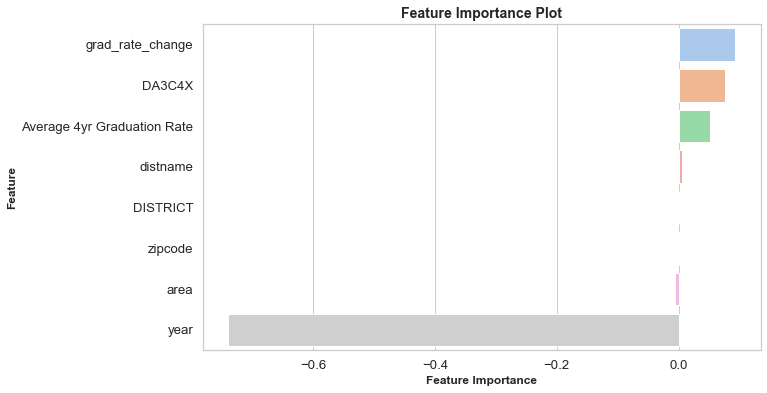



df1:  randomforest .y factor =  median_ppsf
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.12271999 0.30404147 0.13196611 0.05373654 0.28721952 0.03860288
 0.05818702 0.00352647]
model type:  randomforest
MSE: 14314.699103817298
R^2: 0.1383020061860325
RMSE: 119.64405168589577
MAE: 46.9203948058946


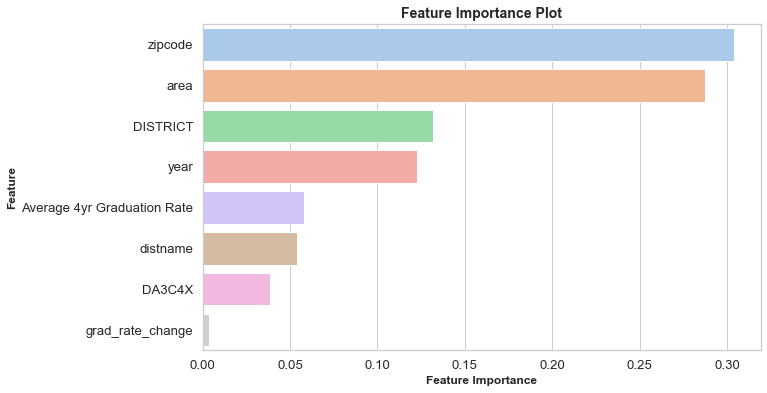



df1:  randomforest .y factor =  Year-over-year change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.06393996 0.15191029 0.2075689  0.0943933  0.20136924 0.23021533
 0.0468929  0.00371007]
model type:  randomforest
MSE: 11563.427873441016
R^2: 0.07891763308068023
RMSE: 107.53338027534062
MAE: 21.134423740610377


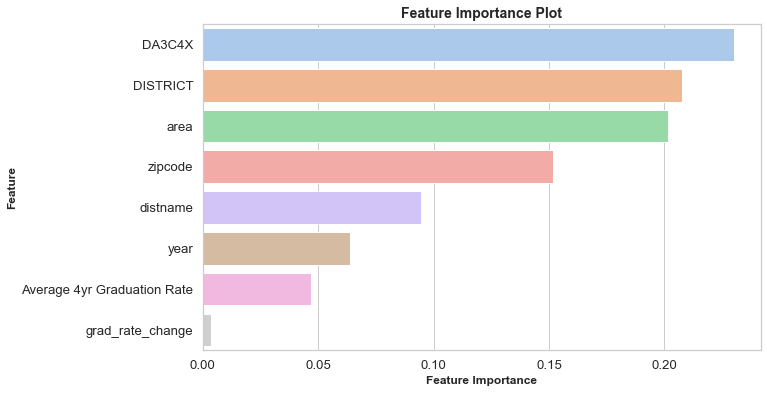



df1:  randomforest .y factor =  Rolling 4-yr Change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.09432237 0.21372209 0.13440363 0.14144422 0.22647174 0.05365
 0.10459619 0.03138976]
randomforest . r2<0


df1:  randomforest .y factor =  Average 4yr PPSF
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.19261211 0.37209113 0.20513881 0.07210333 0.08164016 0.02508362
 0.04786367 0.00346718]
model type:  randomforest
MSE: 3399.1785327648868
R^2: 0.26502968520119985
RMSE: 58.302474499500335
MAE: 30.88455175835436


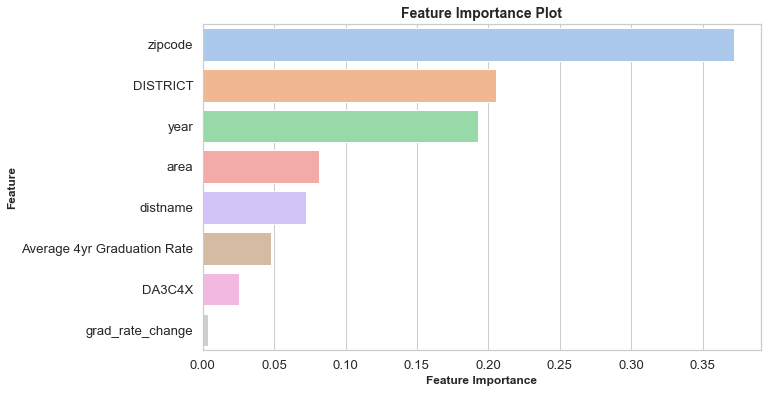



df1:  randomforest .y factor =  home_price_change_1_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.10832278 0.35039724 0.12062355 0.0810229  0.1895859  0.04518166
 0.09849814 0.00636784]
randomforest . r2<0


df1:  randomforest .y factor =  home_price_change_2_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.1103483  0.08022721 0.30164353 0.25292988 0.09568376 0.07707442
 0.0790365  0.0030564 ]
randomforest . r2<0


df1:  randomforest .y factor =  home_price_change_3_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.04326472 0.13043582 0.2980223  0.19817431 0.09384141 0.02695457
 0.20556718 0.00373969]
randomforest . r2<0


-------------------------------------------------
df2:  

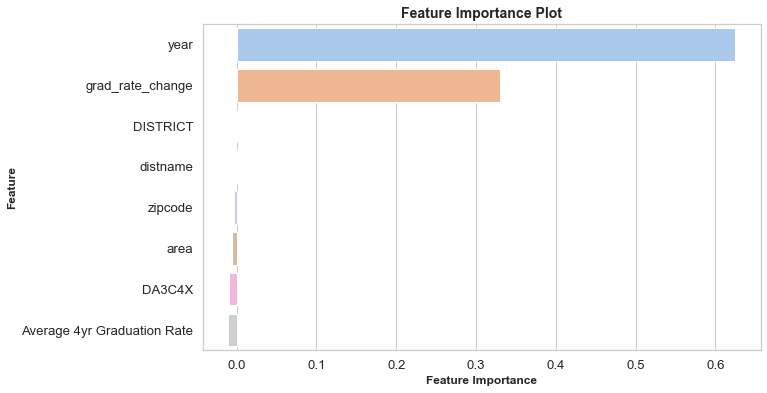



df2:  linear .y factor =  home_price_change_3_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
coef:  [-4.80701880e-02 -4.88886903e-03  1.46127913e-05 -2.08304043e-03
 -9.67750543e-03 -3.45603856e-02 -1.63329695e-03  6.62881988e-01]
intercept:  521.117955729613
score:  <bound method RegressorMixin.score of LinearRegression()>
model type:  linear
MSE: 452.02354020514787
R^2: 0.10665488523712463
RMSE: 21.260845237317067
MAE: 12.65995383262224


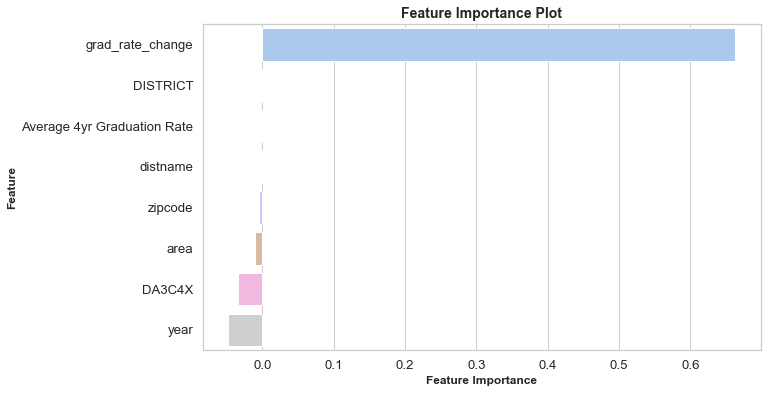



df2:  randomforest .y factor =  median_ppsf
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.09126193 0.25075586 0.09067421 0.05099177 0.3544728  0.04558733
 0.04484647 0.07140964]
randomforest . r2<0


df2:  randomforest .y factor =  Year-over-year change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.0948134  0.2550278  0.08477332 0.07060718 0.28111917 0.09610126
 0.05972469 0.05783316]
randomforest . r2<0


df2:  randomforest .y factor =  Rolling 4-yr Change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.11060995 0.27730264 0.07592983 0.08959993 0.25009733 0.05177461
 0.07949574 0.06518996]
randomforest . r2<0


df2:  randomforest .y factor =  Average 4yr PPSF
Features:  ['year', 'zi

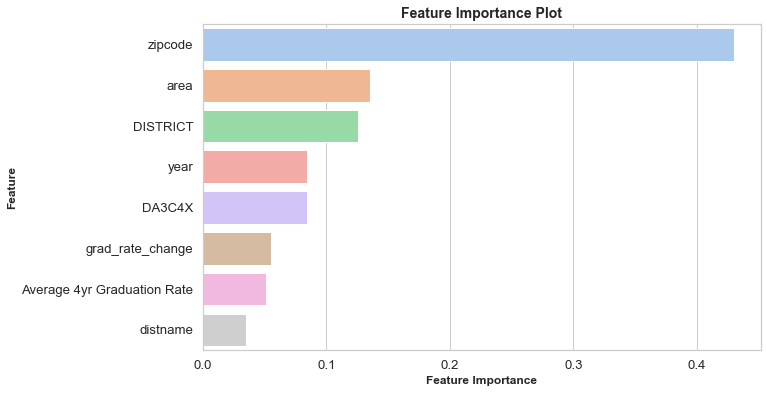



df2:  randomforest .y factor =  home_price_change_1_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.08266744 0.34900506 0.10046464 0.06518317 0.18286233 0.04468751
 0.08673431 0.08839553]
model type:  randomforest
MSE: 56.4370018148494
R^2: 0.17809524147461675
RMSE: 7.512456443457719
MAE: 4.618653894410154


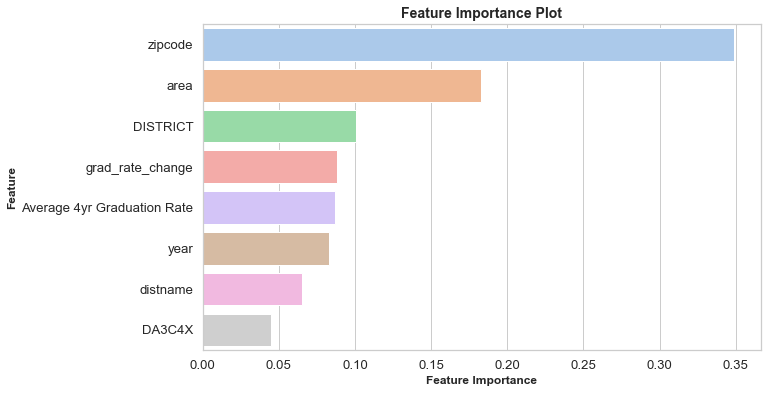



df2:  randomforest .y factor =  home_price_change_2_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.04790342 0.46540708 0.1101695  0.06748425 0.13582699 0.02730754
 0.06992602 0.0759752 ]
model type:  randomforest
MSE: 140.71492643607257
R^2: 0.418867720776698
RMSE: 11.862332251124673
MAE: 7.714115093620983


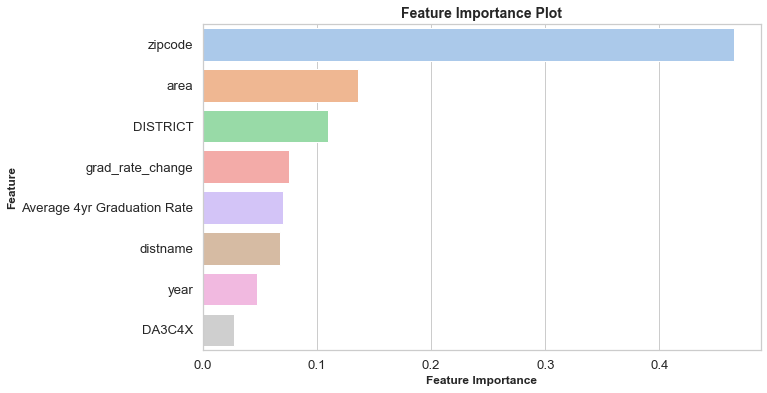



df2:  randomforest .y factor =  home_price_change_3_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.00126497 0.58179257 0.08902801 0.05845984 0.09959824 0.01467442
 0.06668031 0.08850163]
model type:  randomforest
MSE: 242.77335229300786
R^2: 0.5202011201294177
RMSE: 15.581185843606637
MAE: 9.319409447187578


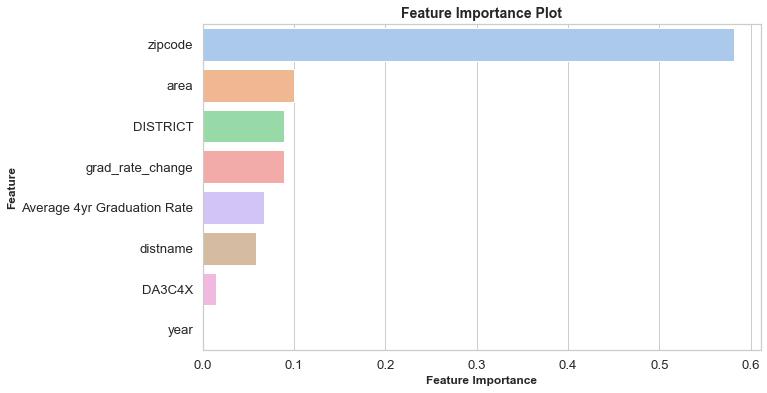



-------------------------------------------------
df3:  linear .y factor =  median_ppsf
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
coef:  [ 8.59598462e+00 -1.85705331e-02 -1.37933193e-04  1.00775301e-01
  7.25607708e-02  9.27810463e-01 -1.18834397e+00 -6.96083251e-01]
intercept:  -15899.34938521879
score:  <bound method RegressorMixin.score of LinearRegression()>
model type:  linear
MSE: 3845.3359497478054
R^2: 0.17318662412056873
RMSE: 62.01077285236659
MAE: 39.849260189130746


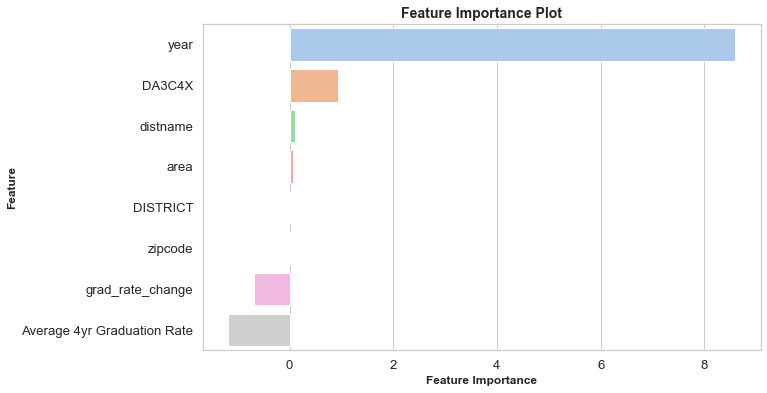



df3:  linear .y factor =  Year-over-year change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
coef:  [-8.88837611e-01 -1.09994271e-03 -1.94014265e-05 -6.64818372e-03
 -8.75520523e-03 -1.24695252e-01  3.21257257e-01  6.63976091e+00]
intercept:  1890.4967659317676
score:  <bound method RegressorMixin.score of LinearRegression()>
linear . r2<0


df3:  linear .y factor =  Rolling 4-yr Change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
coef:  [-5.43005195e-01 -6.58457742e-03 -2.82610052e-05  1.74247269e-02
 -1.94830972e-02  5.65783618e-01  8.19040657e-01  1.76307135e+01]
intercept:  1551.4715907388393
score:  <bound method RegressorMixin.score of LinearRegression()>
linear . r2<0


df3:  linear .y factor =  Average 4yr PPSF
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad

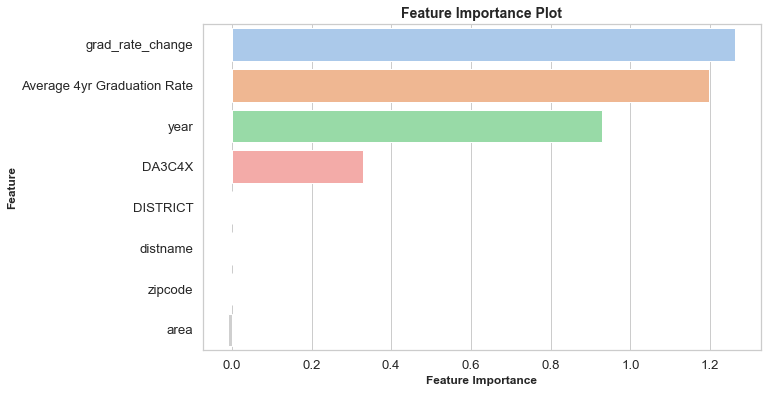



df3:  randomforest .y factor =  median_ppsf
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.10692525 0.33985338 0.01931807 0.03452083 0.44290342 0.02792523
 0.02636297 0.00219084]
model type:  randomforest
MSE: 3160.888531078075
R^2: 0.32035459285926826
RMSE: 56.22177986401778
MAE: 42.08695405449589


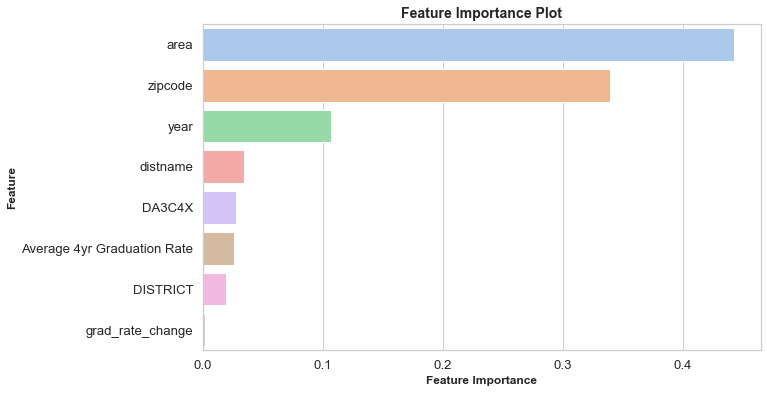



df3:  randomforest .y factor =  Year-over-year change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.15325505 0.22592677 0.01512175 0.02522696 0.42294425 0.11441609
 0.0317946  0.01131452]
randomforest . r2<0


df3:  randomforest .y factor =  Rolling 4-yr Change%
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.09636996 0.29563591 0.01151637 0.01867629 0.44347584 0.07002557
 0.03598844 0.02831162]
randomforest . r2<0


df3:  randomforest .y factor =  Average 4yr PPSF
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.17435751 0.37522836 0.0111717  0.0154733  0.36258643 0.03281935
 0.02586455 0.0024988 ]
model type:  randomforest
MSE: 1972.1998468228805
R^2: 0.5099991865313296
RMSE: 44.409456

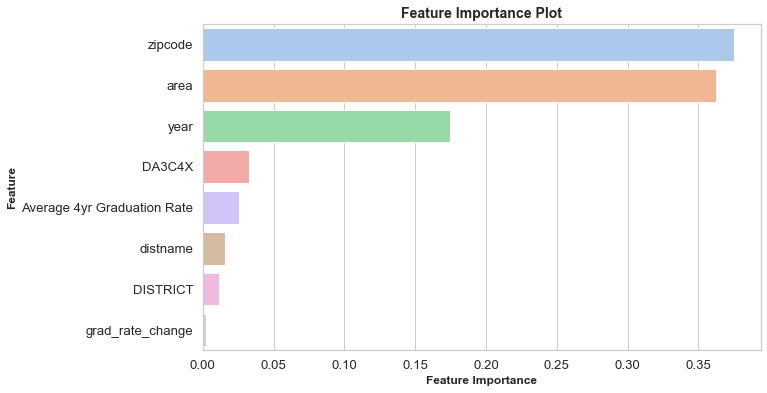



df3:  randomforest .y factor =  home_price_change_1_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.11498325 0.34422092 0.01480124 0.03949374 0.37568223 0.03997891
 0.06370444 0.00713527]
model type:  randomforest
MSE: 36.01197849266211
R^2: 0.12622636688602973
RMSE: 6.000998124700766
MAE: 4.422334492181906


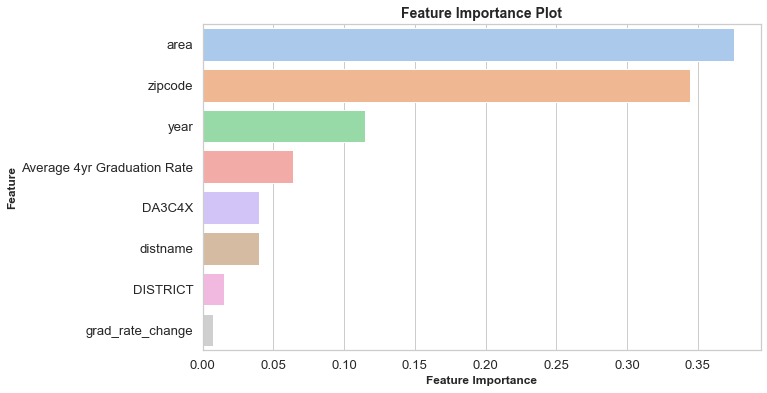



df3:  randomforest .y factor =  home_price_change_2_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.09288797 0.42163787 0.01095914 0.03652111 0.32291372 0.03170134
 0.07700911 0.00636973]
model type:  randomforest
MSE: 132.0950267427852
R^2: 0.2603620178423319
RMSE: 11.493260057215497
MAE: 8.55481015389301


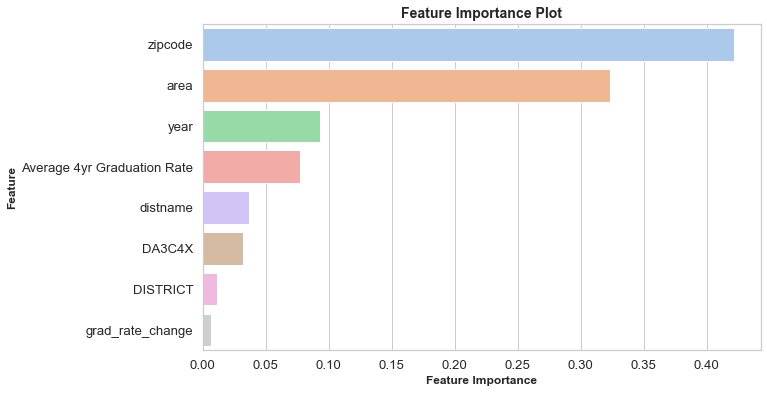



df3:  randomforest .y factor =  home_price_change_3_lag
Features:  ['year', 'zipcode', 'DISTRICT', 'distname', 'area', 'DA3C4X', 'Average 4yr Graduation Rate', 'grad_rate_change']
feature importance:  [0.05025895 0.53437064 0.02140462 0.03097988 0.22446882 0.01916314
 0.11229767 0.0070563 ]
model type:  randomforest
MSE: 277.06198912892205
R^2: 0.43269955348120415
RMSE: 16.645179155807305
MAE: 12.43713131228376


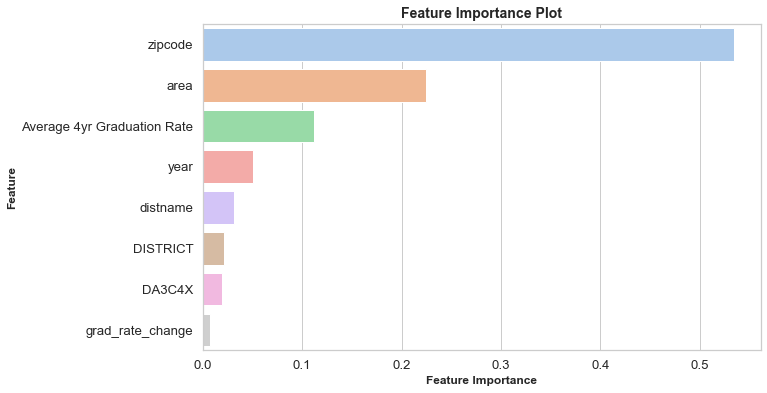

In [91]:
x_base=['year', 'zipcode', 'DISTRICT', 'distname', 'area', ]
x_im=['DA3C4X',  'Average 4yr Graduation Rate', 'grad_rate_change']
x_col=x_base+x_im
y_all=['median_ppsf', 'Year-over-year change%', 'Rolling 4-yr Change%','Average 4yr PPSF', 
 'home_price_change_1_lag', 'home_price_change_2_lag','home_price_change_3_lag']

for model_type in ['linear','randomforest']:
    for y_col in y_all:
        print('df1: ',model_type,'.y factor = ',y_col)
        modelling(df1,model_type,x_col,y_col)   
        print('\n')

print('-------------------------------------------------')
for model_type in ['linear','randomforest']:
    for y_col in y_all:
        print('df2: ',model_type,'.y factor = ',y_col)
        modelling(df2,model_type,x_col,y_col)   
        print('\n')


print('-------------------------------------------------')
for model_type in ['linear','randomforest']:
    for y_col in y_all:
        print('df3: ',model_type,'.y factor = ',y_col)
        modelling(df3,model_type,x_col,y_col)   
        print('\n')

In [ ]:
# df2,linear, y=['home_price_change_3_lag','Rolling 4-yr Change%'],x='grad_rate_change'
x_base=['year', 'zipcode', 'DISTRICT', 'distname', 'area', ]
x_im=['DA3C4X',  'Average 4yr Graduation Rate', 'grad_rate_change']
x_col=x_base+x_im

for model_type in ['randomforest','linear']:
    for y_col in ['home_price_change_3_lag','Rolling 4-yr Change%','median_ppsf']:
        print('df2: ',model_type,'.y factor = ',y_col)
        modelling(df2,model_type,x_col,y_col)   
        print('\n')
        
### 
        
y_col='home_price_change_3_lag'
model_type='linear'
print('df2: ',model_type,'.y factor = ',y_col)
modelling(df2,model_type,x_col,y_col)   
print('\n')